Escolhi trabalhar com o MNIST, por ser uma base já bem estabelecida e que não requer limpeza. MNIST consiste em 70000 imagens  28x28 de dígitos de 0 a 9 escritos à mão, dos quais 60000 foram separados para treinamento e 10000 para teste. Cada imagem é representada por uma matrix 28x28, na qual cada entrada representa a intensidade do pixel naquela posição, variando entre 0 e 255.

Vou tentar determinar a qualidade da predição dos dígitos utilizando KNN. Como features de cada imagem, utilizarei a soma dos pixels das duas primeiras colunas, da segunda e terceira colunas, da quarta e quinta e assim por diante, e o mesmo para com as linhas. Pretendo assim obter uma descrição da intensidade dos pixels distribuídos em linhas e colunas. Espero que dígitos diferentes apresentem perfis diferentes. Por exemplo, é de se esperar que o dígito 1 apresente intensidade não nula, e também alta, em apenas poucas colunas ao centro da imagem e uma intensidade baixa não nula em bastante linhas. O dígito 0 deve apresentar intensidades relativamente uniformes devido à sua simetria.

Tentarei o treinamento com os dados como estão e com uma transformação para normalizar os dados de treinamento (com média 0 e variância 1), então aplicada nos dados de treinamento.

Como a dimensão dos dados é alta, não há um meio simples de visualizar a distribuição dos dados no espaço. Para esse fim, utilizei o PCA para reduzir os dados a duas dimensões. A distribuicão dos dados puros e normalizados pode ser encontrada no final do notebook.

In [1]:
import numpy as np
import mnist
import scipy
from PIL import Image
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import multiprocessing
import random
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(suppress=True)

In [3]:
train_set, train_labels = mnist.train_images(), mnist.train_labels()

test_set, test_labels = mnist.test_images(), mnist.test_labels()

N = train_set.shape[0]
N_test = test_set.shape[0]

In [4]:
def render(i):
    return Image.fromarray(train_set[i])

render(30)

In [5]:
def get_feats(image):
    feats = np.zeros(28)
    for i in range(0,14):
        feats[i] = np.sum(image[:,2*i:2*(i+1)])
    for i in range(0,14):
        feats[i+14] = np.sum(image[2*i:2*(i+1),:])
    #feats[28] = np.sum(image[10:20,10:20])
    return feats/255

In [6]:
training = np.zeros((28,N))
for i in range(0,N):
    training[:,i] = get_feats(train_set[i])

test = np.zeros((28,N_test))
for i in range(0,N_test):
    test[:,i] = get_feats(test_set[i])

In [7]:
scaler = sklearn.preprocessing.StandardScaler().fit(training.T)

training_norm = scaler.transform(training.T).T
test_norm = scaler.transform(test.T).T

In [8]:
class knn_model:
    def __init__(self, k, data, labels):
        self.data = data.copy()
        self.labels = labels.copy()
        self.labeled_data = list(zip(self.data.T, self.labels))
        self.data_dim = len(data[:,0])
        self.k = k
    def change_k(self,k):
        self.k = k
    def dist(self,x,y):
        return np.linalg.norm(x-y)
    def predict(self,x):
        dists = []
        for (d,l) in self.labeled_data:
            dists.append((l,self.dist(x,d)))
        dists.sort(key=lambda x:x[1])
        knn = dists[0:self.k]
        ys = np.zeros(10)
        for l,dist in knn:
            ys[l] += 1
        y = np.random.choice(np.where(ys==np.max(ys))[0])
        return y

Criamos então um modelo 1-NN para os dados não normalizados

In [9]:
m = knn_model(1,training, train_labels)

Abaixo estão as predições do meu modelo para os 10 primeiros dados de teste.

In [10]:
%%time
[m.predict(test.T[i]) for i in range(0,10)]

CPU times: user 8.49 s, sys: 120 ms, total: 8.61 s
Wall time: 8.53 s


[7, 2, 1, 0, 4, 1, 4, 9, 2, 9]

In [11]:
%%time
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=4)
knn.fit(training.T, train_labels)

CPU times: user 125 ms, sys: 5.71 ms, total: 131 ms
Wall time: 130 ms


Aqui estão as predições de um modelo obtido de um pacote para os mesmos dados. Pode-se observar que as predições são iguais. No entanto, o modelo do pacote é diversas vezes mais rápido que o meu. Por questões de tempo computacional, utilizarei o modelo pronto várias vezes a seguir.

In [12]:
%%time
knn.predict(test.T[0:10])

CPU times: user 15.5 ms, sys: 2.07 ms, total: 17.6 ms
Wall time: 109 ms


array([7, 2, 1, 0, 4, 1, 4, 9, 2, 9], dtype=uint8)

Aqui estão algumas predições para dados de teste aleatórios.

In [13]:
ex = []
for _ in range(0,10):
    r = np.random.randint(N_test)
    ex.append((m.predict(test.T[r]), test_labels[r]))
print(ex)

[(9, 4), (0, 0), (7, 7), (0, 0), (1, 1), (6, 6), (1, 1), (5, 5), (2, 2), (7, 7)]


Aqui vemos que o erro de teste é de 12,06%. A tabela que segue é a matrix de confusão do modelo.

In [14]:
%%time
predicted_labels = knn.predict(test.T)

print(np.sum(predicted_labels - test_labels != 0)/N_test)
print(sklearn.metrics.confusion_matrix(test_labels, predicted_labels))

0.1206
[[ 950    8    3    1    1    0    3    5    8    1]
 [   1 1107    5    3    0    1    6    0   11    1]
 [   8    1  899   17    6   45   34   13    9    0]
 [   2    8   45  815    1   70    2   25   26   16]
 [   1    5    4    0  869    1    4    4    1   93]
 [  16    7   56  112    3  620    7   19   40   12]
 [   6    9   14    0    6    3  916    0    3    1]
 [   1   16   12   15    5    6    0  919    8   46]
 [  30   41    5   21    4   20   19   20  803   11]
 [   5   13    0   12   45    8    0   18   12  896]]
CPU times: user 9.87 s, sys: 19 ms, total: 9.89 s
Wall time: 2.96 s


Aqui treinamos o modelo para os dados normalizados. Obtemos um erro de teste de 12,64%.

In [15]:
%%time
knn_norm = KNeighborsClassifier(n_neighbors=1, n_jobs=4)
knn_norm.fit(training_norm.T, train_labels)

predicted_labels_norm = knn_norm.predict(test_norm.T)

print(np.sum(predicted_labels_norm - test_labels != 0)/N_test)
print(sklearn.metrics.confusion_matrix(test_labels, predicted_labels_norm))

0.1264
[[ 944    8    4    2    0    2    3    4   11    2]
 [   3 1107    6    2    0    1    6    1    9    0]
 [  15    1  881   27    5   39   37   12   15    0]
 [   7    5   41  815    1   63    0   27   33   18]
 [   2    7    6    1  880    0    7    6    1   72]
 [  14    8   53  131    5  594    6   25   49    7]
 [  10   10   18    0    6    4  905    0    5    0]
 [   0   17   12   17    9    7    0  913    8   45]
 [  32   45    5   20    6   30   14   19  794    9]
 [   4   13    0   16   34    4    0   22   13  903]]
CPU times: user 44.6 s, sys: 93.5 ms, total: 44.7 s
Wall time: 16.7 s


In [ ]:
knn_image = KNeighborsClassifier(n_neighbors=1, n_jobs=4)
knn_image.fit(train_set.reshape(N,28*28), train_labels)

predicted_labels_image = knn_image.predict(test_set.reshape(N_test,28*28))

print(np.sum(predicted_labels_image - test_labels != 0)/N_test)
print(sklearn.metrics.confusion_matrix(test_labels, predicted_labels_image))

In [193]:
knn.predict(test_set.reshape(N_test,28*28)[0:10])

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

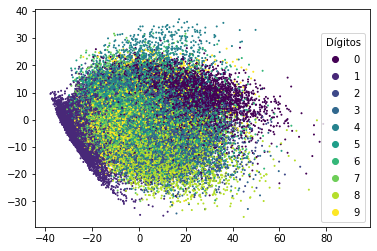

In [16]:
pca = PCA(n_components=2)
pca.fit(training.T)

pca_t = pca.transform(training.T)

ax = plt.scatter(pca_t[:,0], pca_t[:,1], 1, c=train_labels)
ax.axes.legend(*ax.legend_elements(),
                    loc="lower right", title="Dígitos")

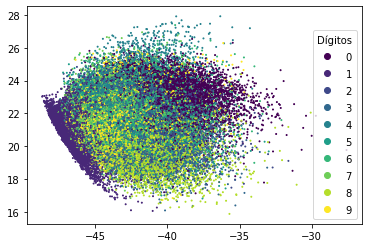

In [17]:
pca_norm = PCA(n_components=2)
pca_norm.fit(training_norm.T)

pca_t_norm = pca.transform(training_norm.T)

ax2 = plt.scatter(pca_t_norm[:,0], pca_t_norm[:,1], 1, c=train_labels)
ax2.axes.legend(*ax2.legend_elements(),
                    loc="lower right", title="Dígitos")

Conseguimos obter uma taxa de acerto de cerca de 88%. No entanto, não foi observada grande diferença entre os modelos com dados normalizados e não normalizados.

Observando a matrix de confusão, podemos ver que o modelo faz bastante erros como trocar 5 e 3, 8 e 2. Assim, creio que uma seleção mais cuidados de features deve levar a um melhor resultado. Por exemplo, uma medida de simetria talvez possa ajudar.